In [43]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.mstats import winsorize
import datetime as dt

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [8]:
df=pd.read_csv("store_sharing.csv",parse_dates=["timestamp"],index_col=["timestamp"])

In [9]:
df

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.000,2.000,93.000,6.000,3.000,0.000,1.000,3.000
2015-01-04 01:00:00,138,3.000,2.500,93.000,5.000,1.000,0.000,1.000,3.000
2015-01-04 02:00:00,134,2.500,2.500,96.500,0.000,1.000,0.000,1.000,3.000
2015-01-04 03:00:00,72,2.000,2.000,100.000,0.000,1.000,0.000,1.000,3.000
2015-01-04 04:00:00,47,2.000,0.000,93.000,6.500,1.000,0.000,1.000,3.000
...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.000,1.000,81.000,19.000,3.000,0.000,0.000,3.000
2017-01-03 20:00:00,541,5.000,1.000,81.000,21.000,4.000,0.000,0.000,3.000
2017-01-03 21:00:00,337,5.500,1.500,78.500,24.000,4.000,0.000,0.000,3.000


# Exploratory Data Analysis and Pre-processing

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cnt,17414.000,1143.102,1085.108,0.000,257.000,844.000,1671.750,7860.000
t1,17414.000,12.468,5.572,-1.500,8.000,12.500,16.000,34.000
t2,17414.000,11.521,6.615,-6.000,6.000,12.500,16.000,34.000
hum,17414.000,72.325,14.313,20.500,63.000,74.500,83.000,100.000
wind_speed,17414.000,15.913,7.895,0.000,10.000,15.000,20.500,56.500
weather_code,17414.000,2.723,2.341,1.000,1.000,2.000,3.000,26.000
is_holiday,17414.000,0.022,0.147,0.000,0.000,0.000,0.000,1.000
is_weekend,17414.000,0.285,0.452,0.000,0.000,0.000,1.000,1.000
season,17414.000,1.492,1.119,0.000,0.000,1.000,2.000,3.000


In [12]:
df["Year"]=df.index.year
df["Month"]=df.index.month
df["Day"]=df.index.day
df["Dayofweek"]=df.index.dayofweek
df["Hour"]=df.index.hour
df["Date"]=df.index.date

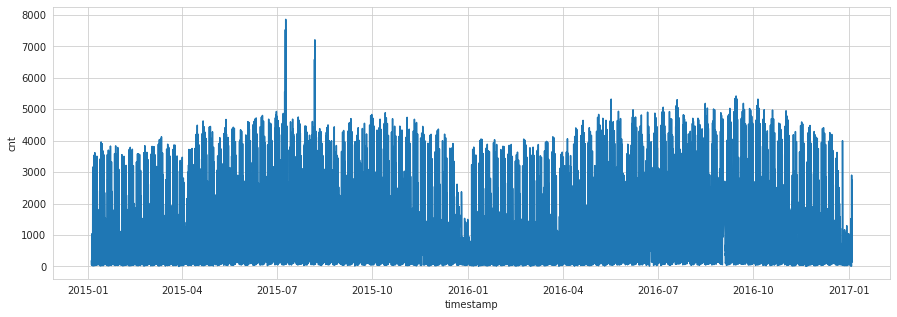

In [13]:
plt.figure(figsize=(15,5))
sns.lineplot(df.index,"cnt",data=df);

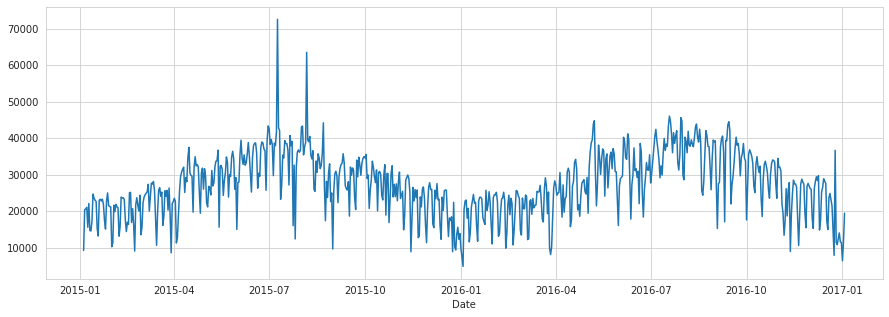

In [16]:
date_cnt=df.groupby("Date")["cnt"].sum()
plt.figure(figsize=(15,5))
sns.lineplot(date_cnt.index,date_cnt.values);

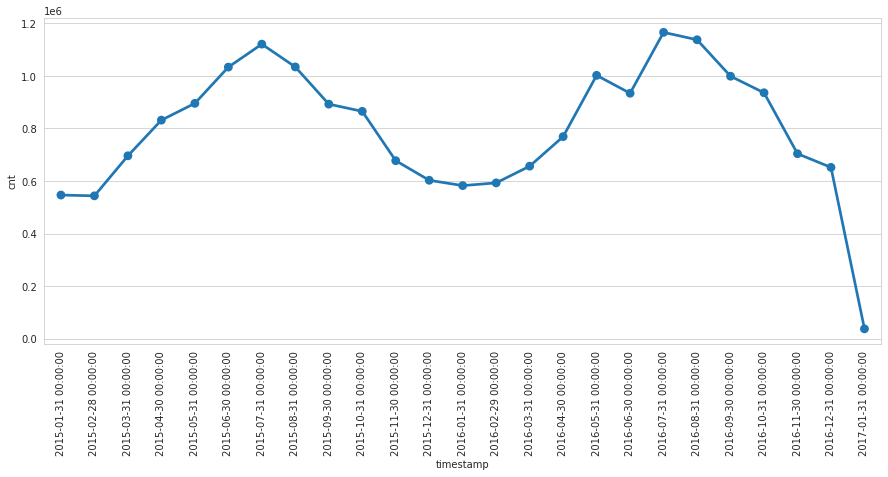

In [18]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
sns.pointplot(x=df.resample("M").sum().index,y=df.resample("M").sum().cnt);

# Unnecesarry Columns

In [20]:
df

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,Year,Month,Day,Dayofweek,Hour,Date
timestamp,,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.000,2.000,93.000,6.000,3.000,0.000,1.000,3.000,2015,1,4,6,0,2015-01-04
2015-01-04 01:00:00,138,3.000,2.500,93.000,5.000,1.000,0.000,1.000,3.000,2015,1,4,6,1,2015-01-04
2015-01-04 02:00:00,134,2.500,2.500,96.500,0.000,1.000,0.000,1.000,3.000,2015,1,4,6,2,2015-01-04
2015-01-04 03:00:00,72,2.000,2.000,100.000,0.000,1.000,0.000,1.000,3.000,2015,1,4,6,3,2015-01-04
2015-01-04 04:00:00,47,2.000,0.000,93.000,6.500,1.000,0.000,1.000,3.000,2015,1,4,6,4,2015-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.000,1.000,81.000,19.000,3.000,0.000,0.000,3.000,2017,1,3,1,19,2017-01-03
2017-01-03 20:00:00,541,5.000,1.000,81.000,21.000,4.000,0.000,0.000,3.000,2017,1,3,1,20,2017-01-03
2017-01-03 21:00:00,337,5.500,1.500,78.500,24.000,4.000,0.000,0.000,3.000,2017,1,3,1,21,2017-01-03


In [22]:
df=df.drop(["t2","Date","Year","season","Month","Dayofweek","Day","Hour"],axis=1)

In [23]:
df

,cnt,t1,hum,wind_speed,weather_code,is_holiday,is_weekend
timestamp,,,,,,,
2015-01-04 00:00:00,182,3.000,93.000,6.000,3.000,0.000,1.000
2015-01-04 01:00:00,138,3.000,93.000,5.000,1.000,0.000,1.000
2015-01-04 02:00:00,134,2.500,96.500,0.000,1.000,0.000,1.000
2015-01-04 03:00:00,72,2.000,100.000,0.000,1.000,0.000,1.000
2015-01-04 04:00:00,47,2.000,93.000,6.500,1.000,0.000,1.000
...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.000,81.000,19.000,3.000,0.000,0.000
2017-01-03 20:00:00,541,5.000,81.000,21.000,4.000,0.000,0.000
2017-01-03 21:00:00,337,5.500,78.500,24.000,4.000,0.000,0.000


In [24]:
wet=pd.get_dummies(df["weather_code"].astype("str"),prefix="w_code",drop_first=True)
df=pd.concat([df,wet],axis=1).drop(["weather_code"],axis=1)

In [25]:
df

,cnt,t1,hum,wind_speed,is_holiday,is_weekend,w_code_10.0,w_code_2.0,w_code_26.0,w_code_3.0,w_code_4.0,w_code_7.0
timestamp,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.000,93.000,6.000,0.000,1.000,0,0,0,1,0,0
2015-01-04 01:00:00,138,3.000,93.000,5.000,0.000,1.000,0,0,0,0,0,0
2015-01-04 02:00:00,134,2.500,96.500,0.000,0.000,1.000,0,0,0,0,0,0
2015-01-04 03:00:00,72,2.000,100.000,0.000,0.000,1.000,0,0,0,0,0,0
2015-01-04 04:00:00,47,2.000,93.000,6.500,0.000,1.000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.000,81.000,19.000,0.000,0.000,0,0,0,1,0,0
2017-01-03 20:00:00,541,5.000,81.000,21.000,0.000,0.000,0,0,0,0,1,0
2017-01-03 21:00:00,337,5.500,78.500,24.000,0.000,0.000,0,0,0,0,1,0


In [32]:
train_size=int(np.round(df.shape[0]*.9))
test_size=df.shape[0]-train_size

In [33]:
train,test=df.iloc[0:train_size],df.iloc[train_size : ]
print(train.shape[0],test.shape[0])

15673 1741


# SCALING

In [34]:
f_scaler=RobustScaler()
target_scaler=RobustScaler()

In [37]:
f_columns=["t1","hum","wind_speed"]
train.loc[:,f_columns]=f_scaler.fit_transform(train[f_columns])
train["cnt"]=target_scaler.fit_transform(train[["cnt"]])

test.loc[:,f_columns]=f_scaler.transform(test[f_columns])
test["cnt"]=target_scaler.transform(test[["cnt"]])

In [38]:
def  create(X,y,time_steps):
  Xs,ys=[],[]
  for i in range(len(X)-time_steps):
    v=X.iloc[i:(i+time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs),np.array(ys)

In [39]:
time_steps=24

X_train,y_train=create(train,train.cnt, time_steps)
X_test,y_test=create(test,test.cnt,time_steps)

# Modelling

In [40]:
n_features=X_train.shape[2]

In [44]:
model=Sequential()

model.add(Bidirectional(LSTM(units=118,input_shape=(time_steps,n_features))))

model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")

In [45]:
early=EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)

In [46]:
model.fit(X_train,y_train,
          epochs=30,
          batch_size=32,
          validation_split=0.3,     
      callbacks=[early])

Epoch 1/30
343/343 [==============================] - 23s 50ms/step - loss: 0.1556 - val_loss: 0.0887
Epoch 2/30
343/343 [==============================] - 21s 61ms/step - loss: 0.0610 - val_loss: 0.0453
Epoch 3/30
343/343 [==============================] - 16s 47ms/step - loss: 0.0400 - val_loss: 0.0408
Epoch 4/30
343/343 [==============================] - 16s 46ms/step - loss: 0.0320 - val_loss: 0.0283
Epoch 5/30
343/343 [==============================] - 16s 47ms/step - loss: 0.0272 - val_loss: 0.0254
Epoch 6/30
343/343 [==============================] - 16s 45ms/step - loss: 0.0238 - val_loss: 0.0225
Epoch 7/30
343/343 [==============================] - 16s 47ms/step - loss: 0.0224 - val_loss: 0.0215
Epoch 8/30
343/343 [==============================] - 16s 47ms/step - loss: 0.0203 - val_loss: 0.0218
Epoch 9/30
343/343 [==============================] - 17s 50ms/step - loss: 0.0189 - val_loss: 0.0190
Epoch 10/30
343/343 [==============================] - 17s 50ms/step - loss: 0.018

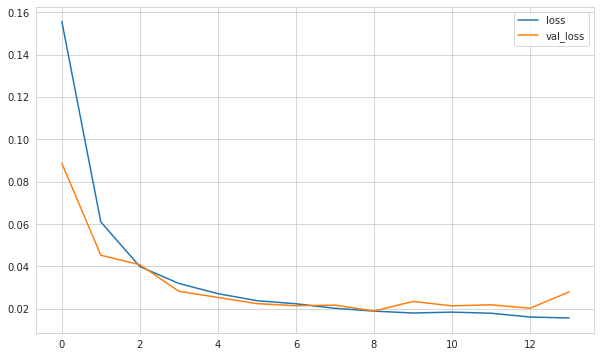

In [47]:
pd.DataFrame(model.history.history).plot();

# Evaluation on Test Data

In [48]:
def ev_metrics(act,pred):
  rmse = np.sqrt(mean_squared_error(act,pred))
  mae=mean_absolute_error(act,pred)
  mse=mean_squared_error(act,pred)
  score=r2_score(act,pred)
  return print("r2_score",score,"mae:",mse,"rmse:",rmse)

In [50]:
y_pred=model.predict(X_test)

In [51]:
ev_metrics(y_test,y_pred)

r2_score 0.9691464852595675 mae: 0.012587097377136341 rmse: 0.11219223403220181


In [52]:
y_train_inv=target_scaler.inverse_transform(y_train.reshape(1,-1))
y_test_inv=target_scaler.inverse_transform(y_test.reshape(1,-1))
y_pred_inv=target_scaler.inverse_transform(y_pred)

In [53]:
test_index=test.iloc[time_steps:].index
pred_test=pd.concat([pd.DataFrame(y_test_inv.reshape(-1,1)),
                     pd.DataFrame(y_pred_inv)], axis=1)
pred_test.columns=["test","prediction"]
pred_test.index=test_index
pred_test

,test,prediction
timestamp,,
2016-10-24 09:00:00,2070.000,2026.781
2016-10-24 10:00:00,968.000,1046.144
2016-10-24 11:00:00,965.000,930.881
2016-10-24 12:00:00,1180.000,1201.027
2016-10-24 13:00:00,1294.000,1225.399
...,...,...
2017-01-03 19:00:00,1042.000,1045.380
2017-01-03 20:00:00,541.000,587.812
2017-01-03 21:00:00,337.000,376.266


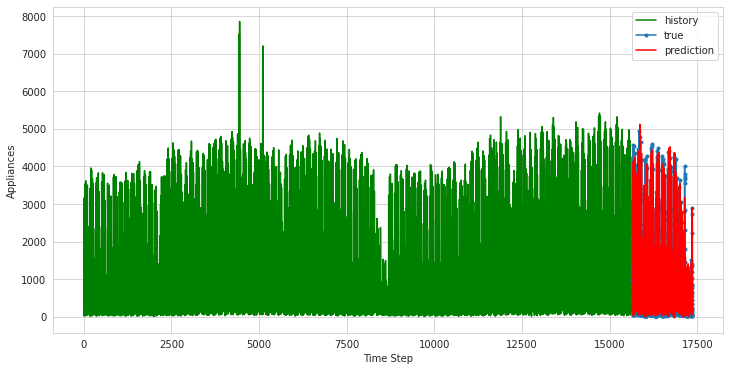

In [54]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0,len(y_train)),y_train_inv.flatten(),"g",label="history")
plt.plot(np.arange(len(y_train),len(y_train)+len(y_test)),y_test_inv.flatten(),marker=".",label="true")
plt.plot(np.arange(len(y_train),len(y_train)+len(y_test)),y_pred_inv.flatten(),"r",label="prediction")
plt.ylabel("Appliances")
plt.xlabel("Time Step")
plt.legend()
plt.show();

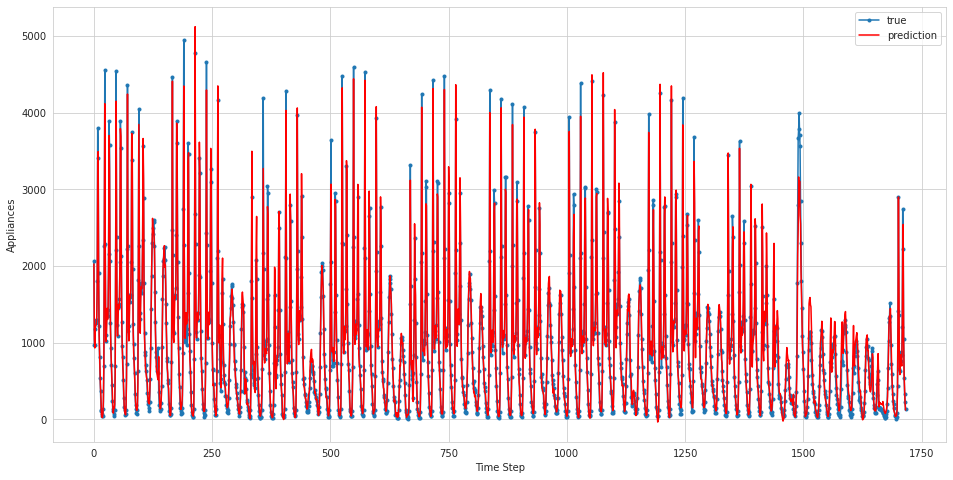

In [55]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten(),marker=".",label="true")
plt.plot(y_pred_inv.flatten(),"r",label="prediction")
plt.ylabel("Appliances")
plt.xlabel("Time Step")
plt.legend();

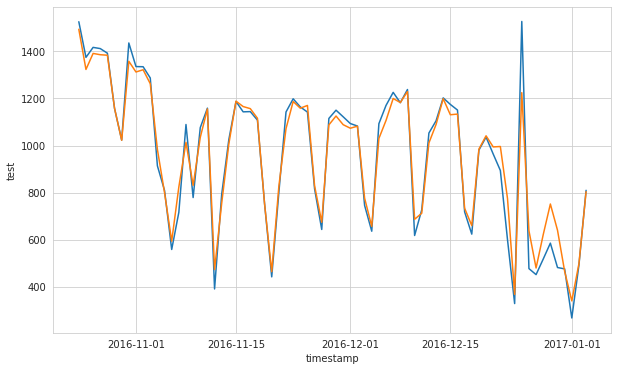

In [57]:
a=pred_test.resample("24H").mean()
sns.lineplot(x=a.index,y="test",data=a)
sns.lineplot(x=a.index,y="prediction",data=a);



# Second Way: After each prediction, result will be used for next prediction

In [58]:
df_fake=test.iloc[:time_steps,1:]
df_fake

,t1,hum,wind_speed,is_holiday,is_weekend,w_code_10.0,w_code_2.0,w_code_26.0,w_code_3.0,w_code_4.0,w_code_7.0
timestamp,,,,,,,,,,,
2016-10-23 09:00:00,-0.438,0.275,-0.455,0.000,1.000,0,1,0,0,0,0
2016-10-23 10:00:00,-0.312,0.025,0.000,0.000,1.000,0,0,0,1,0,0
2016-10-23 11:00:00,-0.125,-0.200,0.636,0.000,1.000,0,1,0,0,0,0
2016-10-23 12:00:00,-0.125,-0.325,0.818,0.000,1.000,0,1,0,0,0,0
2016-10-23 13:00:00,-0.062,-0.300,0.818,0.000,1.000,0,1,0,0,0,0
2016-10-23 14:00:00,0.000,-0.525,0.909,0.000,1.000,0,1,0,0,0,0
2016-10-23 15:00:00,0.000,-0.425,0.727,0.000,1.000,0,1,0,0,0,0
2016-10-23 16:00:00,-0.125,-0.325,0.727,0.000,1.000,0,1,0,0,0,0
2016-10-23 17:00:00,-0.125,-0.200,0.818,0.000,1.000,0,0,0,1,0,0


In [59]:
reel=np.array(test.iloc[:time_steps,:1])
reel.reshape((1,-1))[0]

array([-0.07782369,  0.34573003,  0.71831956,  0.90151515,  1.08677686,
        0.92699725,  1.06680441,  0.83471074,  0.66735537,  0.35743802,
        0.02548209, -0.16666667, -0.27203857, -0.25895317, -0.3815427 ,
       -0.45110193, -0.49655647, -0.54752066, -0.56955923, -0.54683196,
       -0.50344353, -0.18732782,  0.76859504,  2.15426997])

In [61]:
df_fake.shape


(24, 11)

In [62]:
df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1])).shape

(24, 1, 11)

In [63]:
prediction_scaled=[]
first_eval_batch=train.values[-time_steps:]
current_batch=first_eval_batch.reshape((1,time_steps,n_features))
features= df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1]))

for i in range(time_steps):
  current_pred=model.predict(current_batch)
  prediction_scaled.append(current_pred[0])
  new=features[i][0].tolist()
  new.insert(0,current_pred[0][0])
  new=np.array(new).reshape(1,1,n_features)
  current_batch=np.append(current_batch[:,1:,:],new,axis=1)

In [64]:
def ev_metrics(act,pred):
  rmse = np.sqrt(mean_squared_error(act,pred))
  mae=mean_absolute_error(act,pred)
  mse=mean_squared_error(act,pred)
  score=r2_score(act,pred)
  return print("r2_score",score,"mae:",mse,"rmse:",rmse)

In [65]:
ev_metrics(reel,prediction_scaled)

r2_score 0.9341203200712698 mae: 0.032661367662944245 rmse: 0.18072456297621595


In [66]:
predictions=target_scaler.inverse_transform(prediction_scaled)
reel=target_scaler.inverse_transform(reel)

In [67]:
com=pd.DataFrame(data=reel,index=test.index[:time_steps],columns=["reel"])
com["pred"]=predictions

In [68]:
com

,reel,pred
timestamp,,
2016-10-23 09:00:00,744.000,572.031
2016-10-23 10:00:00,1359.000,997.897
2016-10-23 11:00:00,1900.000,1570.736
2016-10-23 12:00:00,2166.000,2089.945
2016-10-23 13:00:00,2435.000,2359.230
2016-10-23 14:00:00,2203.000,2476.647
2016-10-23 15:00:00,2406.000,2490.245
2016-10-23 16:00:00,2069.000,2312.120
2016-10-23 17:00:00,1826.000,1933.322


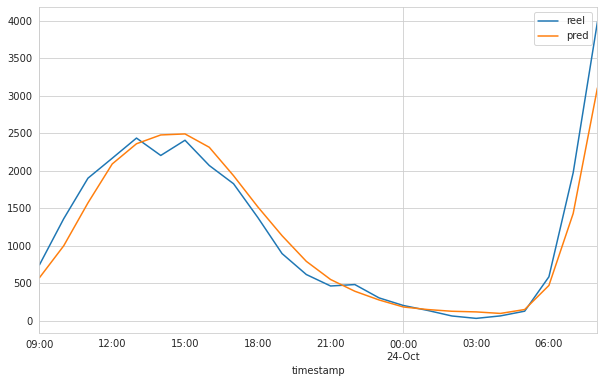

In [69]:
com.plot()


# Retrain and Forecast with Full Data

In [70]:
val_size=24
val=df.iloc[-val_size:]
full=df.iloc[:-val_size]
print(len(full),len(val))

17390 24


In [72]:
f_columns=["t1","hum","wind_speed"]
full.loc[:,f_columns]=f_scaler.fit_transform(full[f_columns])
full["cnt"]=target_scaler.fit_transform(full[["cnt"]])

val.loc[:,f_columns]=f_scaler.transform(val[f_columns])
val["cnt"]=target_scaler.transform(val[["cnt"]])


In [73]:
def  create(X,y,time_steps):
  Xs,ys=[],[]
  for i in range(len(X)-time_steps):
    v=X.iloc[i:(i+time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(Xs),np.array(ys)

In [74]:
X,y=create(full,full.cnt,time_steps)

In [75]:
model=Sequential()

model.add(Bidirectional(LSTM(units=118,input_shape=(time_steps,n_features))))

model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(optimizer="adam",loss="mse")

In [76]:
model.fit(X,y,epochs=30,batch_size=32)

Epoch 1/30
543/543 [==============================] - 28s 42ms/step - loss: 0.1319
Epoch 2/30
543/543 [==============================] - 23s 42ms/step - loss: 0.0426
Epoch 3/30
543/543 [==============================] - 23s 42ms/step - loss: 0.0321
Epoch 4/30
543/543 [==============================] - 26s 48ms/step - loss: 0.0272
Epoch 5/30
543/543 [==============================] - 24s 44ms/step - loss: 0.0241
Epoch 6/30
543/543 [==============================] - 23s 41ms/step - loss: 0.0214
Epoch 7/30
543/543 [==============================] - 22s 41ms/step - loss: 0.0205
Epoch 8/30
543/543 [==============================] - 30s 55ms/step - loss: 0.0200
Epoch 9/30
543/543 [==============================] - 34s 62ms/step - loss: 0.0201
Epoch 10/30
543/543 [==============================] - 23s 42ms/step - loss: 0.0181
Epoch 11/30
543/543 [==============================] - 25s 45ms/step - loss: 0.0181
Epoch 12/30
543/543 [==============================] - 24s 44ms/step - loss: 0.0173
E

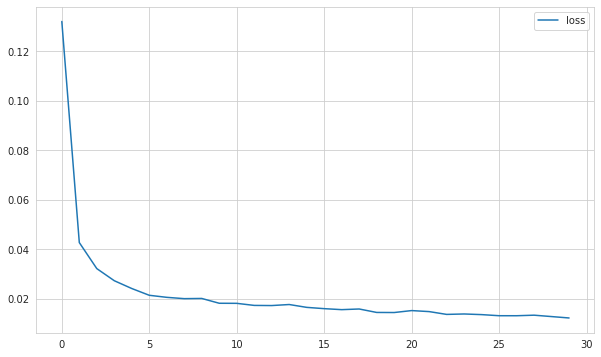

In [78]:
pd.DataFrame(model.history.history).plot();

# Forecasting

In [79]:
df_fake=val.iloc[:,1:]
df_fake

,t1,hum,wind_speed,is_holiday,is_weekend,w_code_10.0,w_code_2.0,w_code_26.0,w_code_3.0,w_code_4.0,w_code_7.0
timestamp,,,,,,,,,,,
2017-01-03 00:00:00,-1.438,0.775,-0.381,0.000,0.000,0,0,0,0,0,0
2017-01-03 01:00:00,-1.438,0.625,-0.476,0.000,0.000,0,0,0,0,0,0
2017-01-03 02:00:00,-1.500,0.775,-0.381,0.000,0.000,0,0,0,0,0,0
2017-01-03 03:00:00,-1.562,0.925,-0.190,0.000,0.000,0,0,0,0,0,0
2017-01-03 04:00:00,-1.562,0.925,-0.095,0.000,0.000,0,0,0,0,0,0
2017-01-03 05:00:00,-1.500,0.775,-0.095,0.000,0.000,0,0,0,1,0,0
2017-01-03 06:00:00,-1.438,0.625,0.286,0.000,0.000,0,0,0,0,0,0
2017-01-03 07:00:00,-1.438,0.625,0.381,0.000,0.000,0,0,0,0,0,0
2017-01-03 08:00:00,-1.438,0.625,0.333,0.000,0.000,0,0,0,1,0,0


In [80]:
reel=np.array(val.iloc[:,:1])
reel.reshape((1,-1))[0]

array([-5.51553672e-01, -5.61440678e-01, -5.65677966e-01, -5.88983051e-01,
       -5.74858757e-01, -5.37429379e-01, -2.89548023e-01,  3.97598870e-01,
        1.45480226e+00,  3.62288136e-01, -1.29237288e-01, -1.46892655e-01,
       -1.34180791e-02,  2.40112994e-02, -5.57909605e-02,  7.06214689e-04,
        2.52118644e-01,  1.34039548e+00,  9.71751412e-01,  1.39830508e-01,
       -2.13983051e-01, -3.58050847e-01, -4.37853107e-01, -4.97881356e-01])

In [93]:
forecast=[]
first_eval_batch=full.values[-time_steps:]
current_batch=first_eval_batch.reshape((1,time_steps,full.shape[1]))
features= df_fake.values.reshape((df_fake.shape[0],1,df_fake.shape[1]))

for i in range(time_steps):
  current_pred=model.predict(current_batch)[0][0]
  forecast.append(current_pred)
  new=features[i][0].tolist()
  new.insert(0,reel[i][0])
  new=np.array(new).reshape(1,1,n_features)
  current_batch=np.append(current_batch[:,1:,:],new,axis=1)

In [94]:
ev_metrics(reel.reshape((1,-1))[0],forecast)

r2_score 0.9540482514326534 mae: 0.015051269029947465 rmse: 0.12268361353476456


In [99]:
forecast1=target_scaler.inverse_transform(np.array(forecast).reshape(1,-1))
forecast_index=pd.date_range(start="2017-01-03 00:00:00",periods=time_steps,freq="H")
forecast_df=pd.DataFrame(data=forecast1.reshape(-1,1),index=forecast_index,columns=["forecast"])
forecast_df

,forecast
2017-01-03 00:00:00,120.047
2017-01-03 01:00:00,41.090
2017-01-03 02:00:00,45.581
2017-01-03 03:00:00,28.465
2017-01-03 04:00:00,-31.813
2017-01-03 05:00:00,94.091
2017-01-03 06:00:00,346.080
2017-01-03 07:00:00,1163.112
2017-01-03 08:00:00,2534.292
2017-01-03 09:00:00,1493.836


(736330.0, 736332.9583333334)

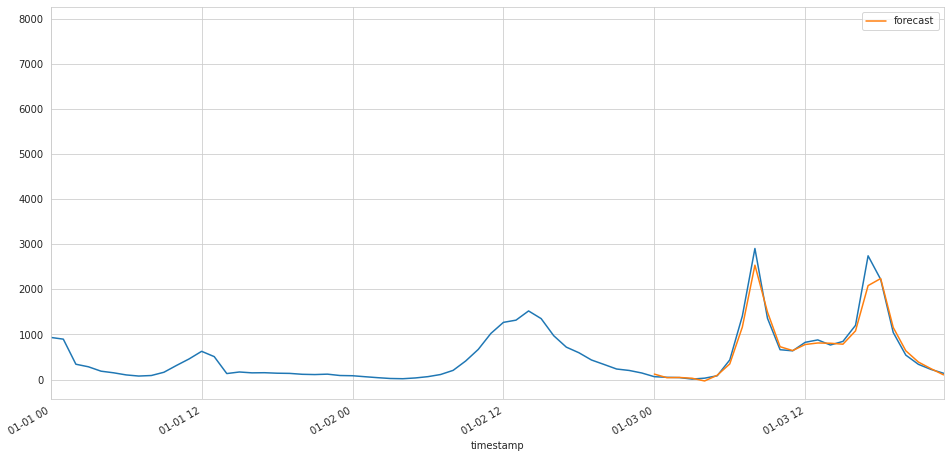

In [100]:
ax=df.cnt.plot()
forecast_df.plot(ax=ax,figsize=(16,8))
plt.xlim("2017-01-01 00:00:00","2017-01-03 23:00:00")